![logo_ironhack_blue 7](spotify_recommender_logo.png)



# Spotify Songs Recommender

![database](img1.png)
![clustering](img2.png)


In [1]:
from bs4 import BeautifulSoup
import requests
import math
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import getpass

Spotify credentials

In [17]:
client_id = getpass.getpass(prompt='input client_id') 
client_secret = getpass.getpass(prompt='input client_secret')

input client_id········
input client_secret········


In [18]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

Get "The Hot 100" Billboard Songs

In [19]:
url = "https://www.billboard.com/charts/hot-100"

In [20]:
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [21]:
titles = []
artists = []
for tag in soup.find_all('span', 'chart-element__information__song text--truncate color--primary'):
    titles.append(tag.get_text())
for tag in soup.find_all('span', 'chart-element__information__artist text--truncate color--secondary'):
    artists.append(tag.get_text())

top100 = pd.DataFrame({'title':titles, 'artist':artists})
top100.head()

,title,artist
0,What's Next,Drake
1,Wants And Needs,Drake Featuring Lil Baby
2,Lemon Pepper Freestyle,Drake Featuring Rick Ross
3,Leave The Door Open,Silk Sonic (Bruno Mars & Anderson .Paak)
4,Drivers License,Olivia Rodrigo


In [22]:
top100.shape

(100, 2)

Get many songs from Spotify

In [23]:
user = 'spotify'

In [26]:
sp.user_playlists(user)

playlists = sp.user_playlists(user)
playlist_uri = []
playlist_names = []

while playlists:
    for playlist in playlists['items']:
        playlist_uri.append(playlist['uri'])
        playlist_names.append(playlist['name'])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

In [27]:
# playlist_names

In [28]:
def get_tracks_from_playlist(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [29]:
def get_all_tracks(uri):

    s_id = []
    s_name = []
    s_artists = []
    
    results = get_tracks_from_playlist("",uri)
    c = 0
    for i in results:
        if i['track'] != None:
            s_id.append("missing value" if i['track']['id'] == None else i['track']['id'])
            s_name.append(i['track']['name'])
            s_artists.append([j['name'] for j in i['track']['artists']])

    return {'song_id':s_id, 'song_name':s_name, 'artists':s_artists}

In [30]:
songs = {'song_id':[], 'song_name':[], 'artists':[]}

for i in tqdm(playlist_uri):
    d = get_all_tracks(i)
    [songs['song_id'].append(i) for i in d['song_id']]
    [songs['song_name'].append(i) for i in d['song_name']]
    [songs['artists'].append(i) for i in d['artists']]

  0%|          | 0/1398 [00:00<?, ?it/s]

In [31]:
df_songs = pd.DataFrame(songs)
df_songs

,song_id,song_name,artists
0,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,"[Bruno Mars, Anderson .Paak, Silk Sonic]"
1,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd]
2,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa]
3,4u4NyuceXP7Uzh7XFJKCr1,Hold On,[Justin Bieber]
4,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,[Masked Wolf]
...,...,...,...
103728,5kqIPrATaCc2LqxVWzQGbk,7 Years,[Lukas Graham]
103729,3FCto7hnn1shUyZL42YgfO,Piano Man,[Billy Joel]
103730,3XVBdLihbNbxUwZosxcGuJ,If I Ain't Got You,[Alicia Keys]
103731,6QPKYGnAW9QozVz2dSWqRg,Someone Like You,[Adele]


Remove the duplicates

In [32]:
df_songs = df_songs.drop_duplicates(subset='song_id').reset_index(drop=True)
df_songs

,song_id,song_name,artists
0,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,"[Bruno Mars, Anderson .Paak, Silk Sonic]"
1,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd]
2,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa]
3,4u4NyuceXP7Uzh7XFJKCr1,Hold On,[Justin Bieber]
4,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,[Masked Wolf]
...,...,...,...
82405,2q4rjDy9WhaN3o9MvDbO21,Kiss Me Thru The Phone,"[Soulja Boy, Sammie]"
82406,3Zuf70897YkrVRAsrBMMSF,"You're The One That I Want - From ""Grease"" Ori...","[John Travolta, Olivia Newton-John]"
82407,0ygTmpa6uSotkBkTiwcMZ4,Warwick Avenue,[Duffy]
82408,7GJClzimvMSghjcrKxuf1M,Budapest,[George Ezra]


Let's get the features, 100 ids at a time

In [33]:
features_list = []
for i in tqdm(range(math.ceil(df_songs.shape[0]/100))):
    features_list.append(sp.audio_features(df_songs['song_id'].to_list()[i*100:(i+1)*100]))

  0%|          | 0/825 [00:00<?, ?it/s]

In [35]:
features = []
[[(features.append(j) if j != None else None) for j in i] for i in features_list]
pass

In [36]:
dic = defaultdict(list)
{dic[key].append(f[key]) for f in features for key in f}  
df_features = pd.DataFrame(dict(dic))

In [37]:
df_songs.shape

(82410, 3)

In [38]:
df_features.shape

(82298, 18)

In [39]:
df_features = df_features[df_features['speechiness']<0.8]

In [40]:
df_all = df_songs.merge(df_features.rename({'id':'song_id'}, axis=1), on='song_id', how='right')
df_all.columns

Index(['song_id', 'song_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [41]:
df_all = df_all.drop(['type', 'uri', 'track_href', 'analysis_url'], axis=1)

In [42]:
df_all.head()

,song_id,song_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,"[Bruno Mars, Anderson .Paak, Silk Sonic]",0.586,0.616,5,-7.964,1,0.0324,0.1820,0.000000,0.0927,0.719,148.088,242096,4
1,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd],0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,0.5430,0.644,118.051,215627,4
2,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa],0.722,0.588,6,-5.932,1,0.0544,0.0319,0.000000,0.1830,0.590,134.010,165507,4
3,4u4NyuceXP7Uzh7XFJKCr1,Hold On,[Justin Bieber],0.658,0.634,1,-5.797,0,0.0413,0.0106,0.000000,0.1320,0.290,139.980,170813,4
4,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,[Masked Wolf],0.778,0.695,4,-6.865,0,0.0913,0.1750,0.000000,0.1500,0.472,149.996,132780,4


Feature selection

In [43]:
X_cont = df_all[['danceability','energy','loudness','speechiness',
                       'acousticness','instrumentalness','liveness','valence',
                       'tempo','duration_ms']]

In [44]:
X_disc = df_all[['key','mode','time_signature']]

Standardize

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cont_st = scaler.fit_transform(X_cont)
X_cont_st = pd.DataFrame(X_cont_st, columns=X_cont.columns)

No need to encode the discrete variables

In [46]:
X_disc = X_disc.astype('object')
X_disc

,key,mode,time_signature
0,5,1,4
1,0,1,4
2,6,1,4
3,1,0,4
4,4,0,4
...,...,...,...
77017,7,1,4
77018,0,1,4
77019,0,0,4
77020,5,1,4


Join all features

In [47]:
X_prep = pd.concat([X_cont_st, X_disc], axis=1)
X_prep

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature
0,0.265750,0.266032,0.387126,-0.482498,-0.560561,-0.598172,-0.581761,1.111648,0.960815,0.013403,5,1,4
1,0.758723,0.987256,0.735825,-0.495459,-0.995690,-0.598137,2.279212,0.824708,0.018957,-0.155449,0,1,4
2,0.978987,0.169869,0.673181,-0.292416,-0.966735,-0.598172,-0.008041,0.618111,0.519377,-0.475177,6,1,4
3,0.643346,0.327851,0.692185,-0.405601,-1.024373,-0.598172,-0.332069,-0.529651,0.706576,-0.441329,1,0,4
4,1.272673,0.537350,0.541838,0.026405,-0.579503,-0.598172,-0.217706,0.166658,1.020643,-0.683950,4,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77017,1.167785,0.595734,0.975988,0.205255,-1.002996,-0.598172,-0.740598,1.402414,1.020706,-0.297324,7,1,4
77018,1.131075,0.736545,0.354185,0.045413,-0.438790,-0.595925,0.157149,1.322071,-0.328317,-0.456294,0,1,4
77019,-0.221978,0.176738,0.689792,-0.423746,-0.135715,-0.598172,-0.401957,0.281434,1.645016,-0.086809,0,0,4
77020,0.937032,-0.300643,0.344330,-0.523971,-0.814115,-0.598172,-0.484553,-0.085850,0.324245,-0.250545,5,1,4


Subset of X just for practical purposes (faster processing)

In [48]:
# With 1000 samples we get 7 clusters
X_prep = X_prep.sample(50000)

Cluster

In [49]:
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

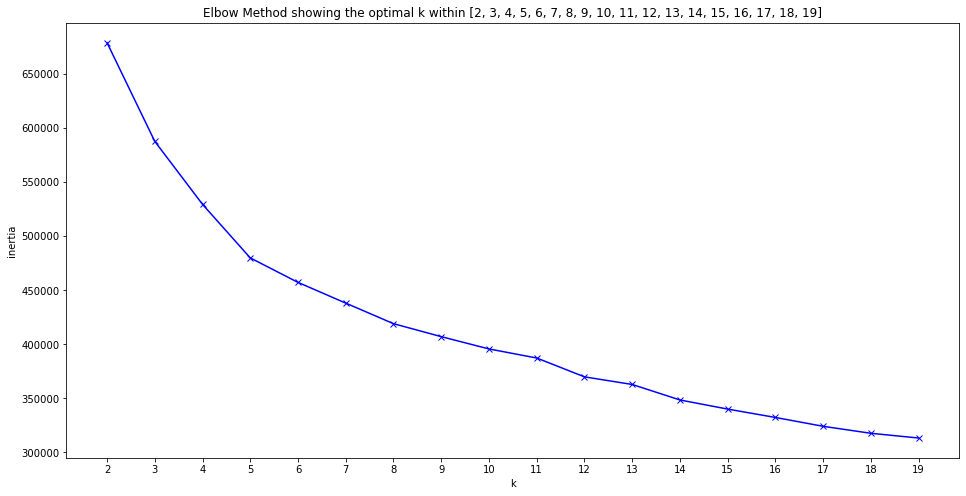

In [50]:
K = range(2,20)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                   )
    kmeans.fit(X_prep)
    inertias.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Silhouette Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

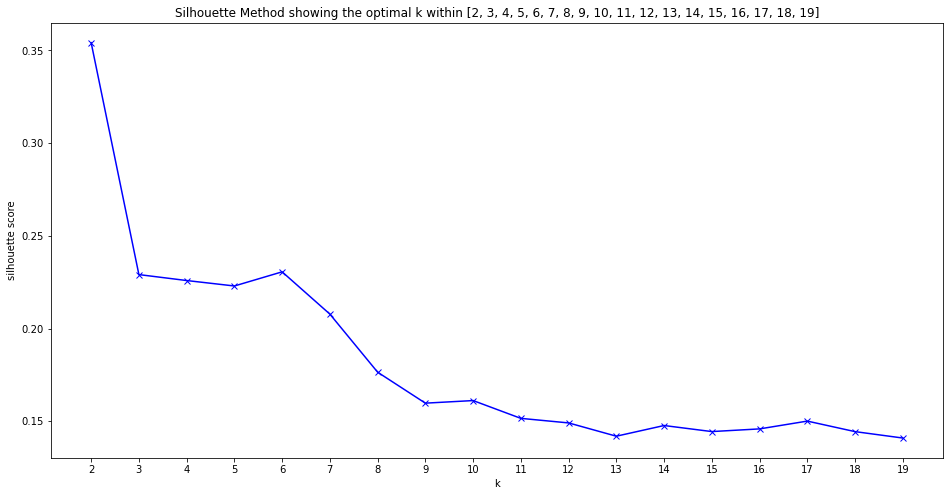

In [51]:
from sklearn.metrics import silhouette_score

import numpy as np
K = range(2,20)
silhouettes = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_prep)
    silhouettes.append(silhouette_score(X_prep, kmeans.predict(X_prep) )
                   )
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Silhouette Method showing the optimal k within {list(K)}')

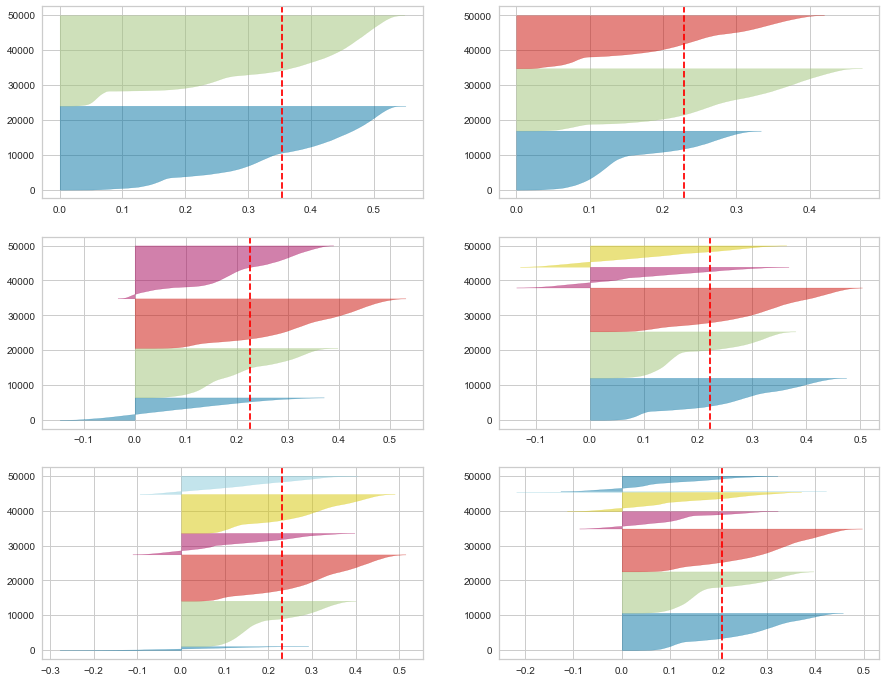

In [52]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,12))
for k in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k,
                random_state=1234)
    q, mod = divmod(k, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_prep)

We decide for 6 clusters

In [53]:
cols = X_prep.columns

In [54]:
kmeans = KMeans(n_clusters=6,
               random_state=1234)
kmeans.fit(X_prep)

clusters = kmeans.predict(X_prep)

In [55]:
clusters.shape

(50000,)

In [56]:
songs_clustered = X_prep.copy()
songs_clustered['cluster_id'] = clusters

In [57]:
songs_clustered

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature,cluster_id
17983,0.926543,0.880789,0.373893,-0.262175,-0.593033,-0.592812,0.722609,1.559275,0.038680,0.982607,1,0,4,2
75746,-0.353088,1.083419,0.962192,-0.430658,-1.052605,-0.598172,-0.708195,-0.384268,0.711279,-0.253690,11,0,4,4
71891,-1.905428,-1.214193,-1.558383,-0.455714,1.542021,1.970167,-0.616705,-1.496831,-1.040237,-0.200755,0,0,4,3
71459,-0.992904,0.777758,0.303506,-0.405601,-1.046861,-0.598151,0.182563,0.824708,-0.344403,0.283442,8,1,4,4
40911,-0.547131,1.419990,0.790305,0.086022,-1.053025,1.316616,3.016216,0.174310,-0.241240,-0.093966,9,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70187,0.150373,-0.650952,-0.082077,-0.498051,1.385071,-0.598159,-0.497260,0.354126,0.583877,-0.366730,11,0,4,4
73673,1.450982,0.190476,0.576468,-0.091965,-0.899896,-0.598119,-0.217706,0.748190,-0.359266,-0.534383,5,1,4,1
57658,0.139885,0.970084,0.792839,-0.523107,-0.241250,-0.598172,2.126729,1.777350,-0.374223,-0.372930,5,1,4,1
42127,-0.589086,1.426859,1.063831,-0.356353,-1.047375,-0.598172,-0.046162,0.273782,0.849969,0.448792,7,0,4,1


In [58]:
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=cols)
cluster_centers_df['cluster_id'] = range(0,6)

In [59]:
# we can only plot 2 dimensions,
# so we take 'danceability', 'loudness'
# we also need the 'cluster_id' to color the dots with
clusters_sub_df = cluster_centers_df[['danceability', 'loudness', 'cluster_id']]
songs_sub_df = songs_clustered[['danceability', 'loudness', 'cluster_id']]

<AxesSubplot:xlabel='danceability', ylabel='loudness'>

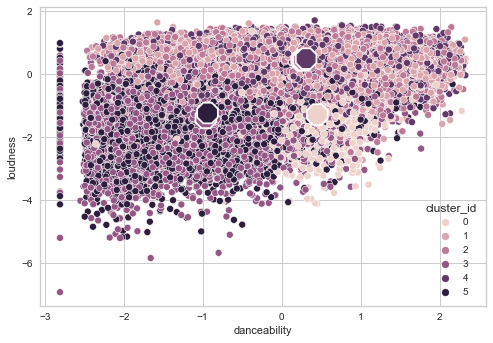

In [60]:
import seaborn as sns

# plot datapoints
sns.scatterplot(data=songs_sub_df,
               x="danceability",
               y="loudness",
               hue='cluster_id')

# plot centroids
sns.scatterplot(data=clusters_sub_df,
               x="danceability",
               y="loudness",
               hue='cluster_id',
                legend=False,
                marker=u'8',
                s=500,
               )


Is a song in the Top 100 list?

In [61]:
def is_hot(song):
    s = top100['title'].str.contains(song, na=False, case=False)
    if s.sum() > 0:
        return True
    else:
        return False

In [62]:
is_hot('Drivers')

True

Ask for user input and recommend song

In [63]:
def recommend():
    print("""
    Enter your song's name. Example:
    >>> where is love?
    """)
    user_input = input()
    
    if is_hot(user_input):
        
        s = top100[top100['title'].str.contains('love', na=False, case=False)].sample()
        
        print('Match found!')
        print('* ' + '"' + s.iloc[0]['title'] + '"' + ' by ' + s.iloc[0]['artist'])
        s = top100.sample()
        print("""Your song is hot!\nHere's another one for you to check out:""")
        print('* ' + '"'+s.iloc[0]['title']+'"' + ' by ' + s.iloc[0]['artist'])
    else:
        
        result = sp.search(q=user_input, type='track', limit=1)
        song_audio_features = sp.audio_features(result['tracks']['items'][0]['id'])
        song_audio_features_df = pd.DataFrame(song_audio_features, columns=X_cont.columns)
        song_scaled = pd.DataFrame(scaler.transform(song_audio_features_df))
        song_disc = pd.DataFrame(song_audio_features, columns=['key','mode','time_signature'])
        song_audio_features = pd.concat([song_scaled,song_disc], axis=1)
        cl = kmeans.predict(song_audio_features)[0]
        recommendation = df_all.iloc[songs_clustered[songs_clustered.cluster_id==cl].sample().index]

        print("""Your song is not in the Top 100.\nThis match was found:""")
        print("* " + str(result['tracks']['items'][0]['name']) +
              " by " +
              str(result['tracks']['items'][0]['artists'][0]['name']))
        print("Here's another one for you to check out:")
        print('* ' + str(recommendation.song_name.iloc[0]) +
              " by "
              + str([i for i in recommendation.artists.iloc[0]][0]))
    pass

Execute

In [64]:
recommend()


    Enter your song's name. Example:
    >>> where is love?
    
where is love
Your song is not in the Top 100.
This match was found:
* Where is love by (G)I-DLE
Here's another one for you to check out:
* Downtown - 64 Original Release With Petula Clark by Petula Clark
